In [2]:
# exp1_baseline.py
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from typing import List, Tuple

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler, PowerTransformer , OrdinalEncoder 
from sklearn.model_selection import StratifiedKFold, TimeSeriesSplit, cross_val_score
from sklearn.metrics import make_scorer, roc_auc_score  , accuracy_score, f1_score, recall_score, precision_score


from sklearn.model_selection import cross_validate
# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC , SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
import pickle

In [3]:
df = pd.read_csv('data/train_merged.csv')

# EXP1: BASELINE

- Missing : num -> median , cat -> 'unknown' , 'D9' Fill -1 , address fill -1 , card fill -1   
- Outlier -> clip by percentiles (1 - 99%)  
- Transform/scale : log1p for Skewness features. 
- Encoding : orinal encoding for categorical 
- NO FE , PCA , SMOTE 
- Model : Logistic, Linear/Kernel SVM, Decision Tree, Random Forest, XGBoost, LightGBM, CatBoost, MLP. 
- CV: 5-fold 
- metric: ROC-AUC, accuracy , f1-score , recall , precision 

In [4]:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
num_cols.remove('isFraud')

tar_cols = ['isFraud']

In [5]:
len(num_cols) + len(cat_cols) + 1 

434

In [6]:
fill_minus_1_cols = ['D9'] + [col for col in df.columns if 'addr' in col if df[col].dtype == 'float64'] + [col for col in df.columns if 'card' in col if df[col].dtype == 'float64']
fill_median_cols = [col for col in num_cols if col not in fill_minus_1_cols] 

In [7]:
len(fill_minus_1_cols) + len(fill_median_cols) + len(cat_cols) + 1

434

In [8]:

# Custom transformer for missing value imputation
class CustomImputer(BaseEstimator, TransformerMixin):
    def __init__(self, fill_minus_1_cols, fill_median_cols, cat_cols):
        self.fill_minus_1_cols = fill_minus_1_cols
        self.fill_median_cols = fill_median_cols
        self.cat_cols = cat_cols
        self.median_values = {}
        
    def fit(self, X, y=None):
        # Calculate median for numerical columns
        for col in self.fill_median_cols:
            if col in X.columns:
                self.median_values[col] = X[col].median()
        return self
    
    def transform(self, X):
        X = X.copy()
        
        # Fill -1 for specific columns
        for col in self.fill_minus_1_cols:
            if col in X.columns:
                X[col] = X[col].fillna(-1)
        
        # Fill median for numerical columns
        for col in self.fill_median_cols:
            if col in X.columns:
                X[col] = X[col].fillna(self.median_values[col])
        
        # Fill 'unknown' for categorical columns
        for col in self.cat_cols:
            if col in X.columns:
                X[col] = X[col].fillna('unknown')
        
        return X

# Custom transformer for outlier clipping
class OutlierClipper(BaseEstimator, TransformerMixin):
    def __init__(self, columns, lower_percentile=1, upper_percentile=99):
        self.columns = columns
        self.lower_percentile = lower_percentile
        self.upper_percentile = upper_percentile
        self.bounds = {}
    
    def fit(self, X, y=None):
        for col in self.columns:
            if col in X.columns:
                lower_bound = np.percentile(X[col], self.lower_percentile)
                upper_bound = np.percentile(X[col], self.upper_percentile)
                self.bounds[col] = (lower_bound, upper_bound)
        return self
    
    def transform(self, X):
        X = X.copy()
        for col in self.columns:
            if col in X.columns and col in self.bounds:
                lower_bound, upper_bound = self.bounds[col]
                X[col] = np.clip(X[col], lower_bound, upper_bound)
        return X

# Custom transformer for log transformation
class LogTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        for col in self.columns:
            if col in X.columns:
                X[col] = np.log1p(X[col] - X[col].min() + 1)  # Ensure positive values
        return X

# Prepare data
X = df.drop('isFraud', axis=1)
y = df['isFraud']

# Identify skewed numerical columns for log transformation
skewed_cols = []
for col in fill_median_cols:
    if col in X.columns:
        skewness = X[col].skew()
        if abs(skewness) > 0.75:  # Threshold for skewness
            skewed_cols.append(col)

print(f"Skewed columns for log transformation: {len(skewed_cols)}")

# Create preprocessing pipeline
preprocessing_pipeline = Pipeline([
    ('custom_imputer', CustomImputer(fill_minus_1_cols, fill_median_cols, cat_cols)),
    ('outlier_clipper', OutlierClipper(num_cols)),
    ('log_transformer', LogTransformer(skewed_cols)),
    ('column_transformer', ColumnTransformer([
        ('num_scaler', RobustScaler(), fill_median_cols + fill_minus_1_cols),
        ('cat_encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_cols)
    ], remainder='passthrough'))
])


Skewed columns for log transformation: 367


In [9]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Linear SVM': LinearSVC(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'XGBoost': RandomForestClassifier(random_state=42, n_estimators=100),  # Placeholder for XGBoost 
    "XGBoost": xgb.XGBClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        use_label_encoder=False,
        eval_metric="logloss",
        random_state=42,
        # scale_pos_weight=scale_pos_weight,     
    ),

    "LightGBM": lgb.LGBMClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=-1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        # scale_pos_weight=scale_pos_weight      
    ),

    "CatBoost": CatBoostClassifier(
        iterations=800,
        depth=8,
        learning_rate=0.05,
        loss_function="Logloss",
        eval_metric="AUC",
        task_type="CPU",       
        devices="0",
        verbose=False,
        random_seed=42,
        # class_weights=[class_weights[0], class_weights[1]]   
    ) , 
    'MLP': MLPClassifier(random_state=42, max_iter=1000, early_stopping=True)
}

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Metrics

def evaluate_model(model, X, y, cv):
    """Evaluate model using cross-validation"""
    
    # ROC-AUC
    auc_scores = cross_val_score(model, X, y, cv=cv, scoring='roc_auc')
    
    # Other metrics using cross_validate
    from sklearn.model_selection import cross_validate
    
    scoring = {
        'accuracy':  make_scorer(accuracy_score),
        'f1':        make_scorer(f1_score, zero_division=0),
        'recall':    make_scorer(recall_score, zero_division=0),
        'precision': make_scorer(precision_score, zero_division=0)
    }
    
    cv_results = cross_validate(model, X, y, cv=cv, scoring=scoring)
    
    results = {
        'ROC-AUC': auc_scores,
        'Accuracy': cv_results['test_accuracy'],
        'F1-Score': cv_results['test_f1'],
        'Recall': cv_results['test_recall'],
        'Precision': cv_results['test_precision']
    }
    
    return results


Skewed columns for log transformation: 367
Starting EXP1: BASELINE

Evaluating Logistic Regression...

Logistic Regression Results:
ROC-AUC: 0.8641 (+/- 0.0066)
Accuracy: 0.9722 (+/- 0.0008)
F1-Score: 0.3974 (+/- 0.0258)
Recall: 0.2623 (+/- 0.0219)
Precision: 0.8214 (+/- 0.0274)

Evaluating Linear SVM...

Linear SVM Results:
ROC-AUC: 0.8651 (+/- 0.0069)
Accuracy: 0.9725 (+/- 0.0004)
F1-Score: 0.3852 (+/- 0.0194)
Recall: 0.2465 (+/- 0.0162)
Precision: 0.8817 (+/- 0.0063)

Evaluating Decision Tree...

Decision Tree Results:
ROC-AUC: 0.7848 (+/- 0.0112)
Accuracy: 0.9676 (+/- 0.0016)
F1-Score: 0.5592 (+/- 0.0198)
Recall: 0.5882 (+/- 0.0220)
Precision: 0.5329 (+/- 0.0206)

Evaluating Random Forest...

Random Forest Results:
ROC-AUC: 0.9297 (+/- 0.0031)
Accuracy: 0.9796 (+/- 0.0005)
F1-Score: 0.6020 (+/- 0.0150)
Recall: 0.4416 (+/- 0.0165)
Precision: 0.9460 (+/- 0.0075)

Evaluating XGBoost...

XGBoost Results:
ROC-AUC: 0.9284 (+/- 0.0044)
Accuracy: 0.9785 (+/- 0.0010)
F1-Score: 0.5842 (+/- 0

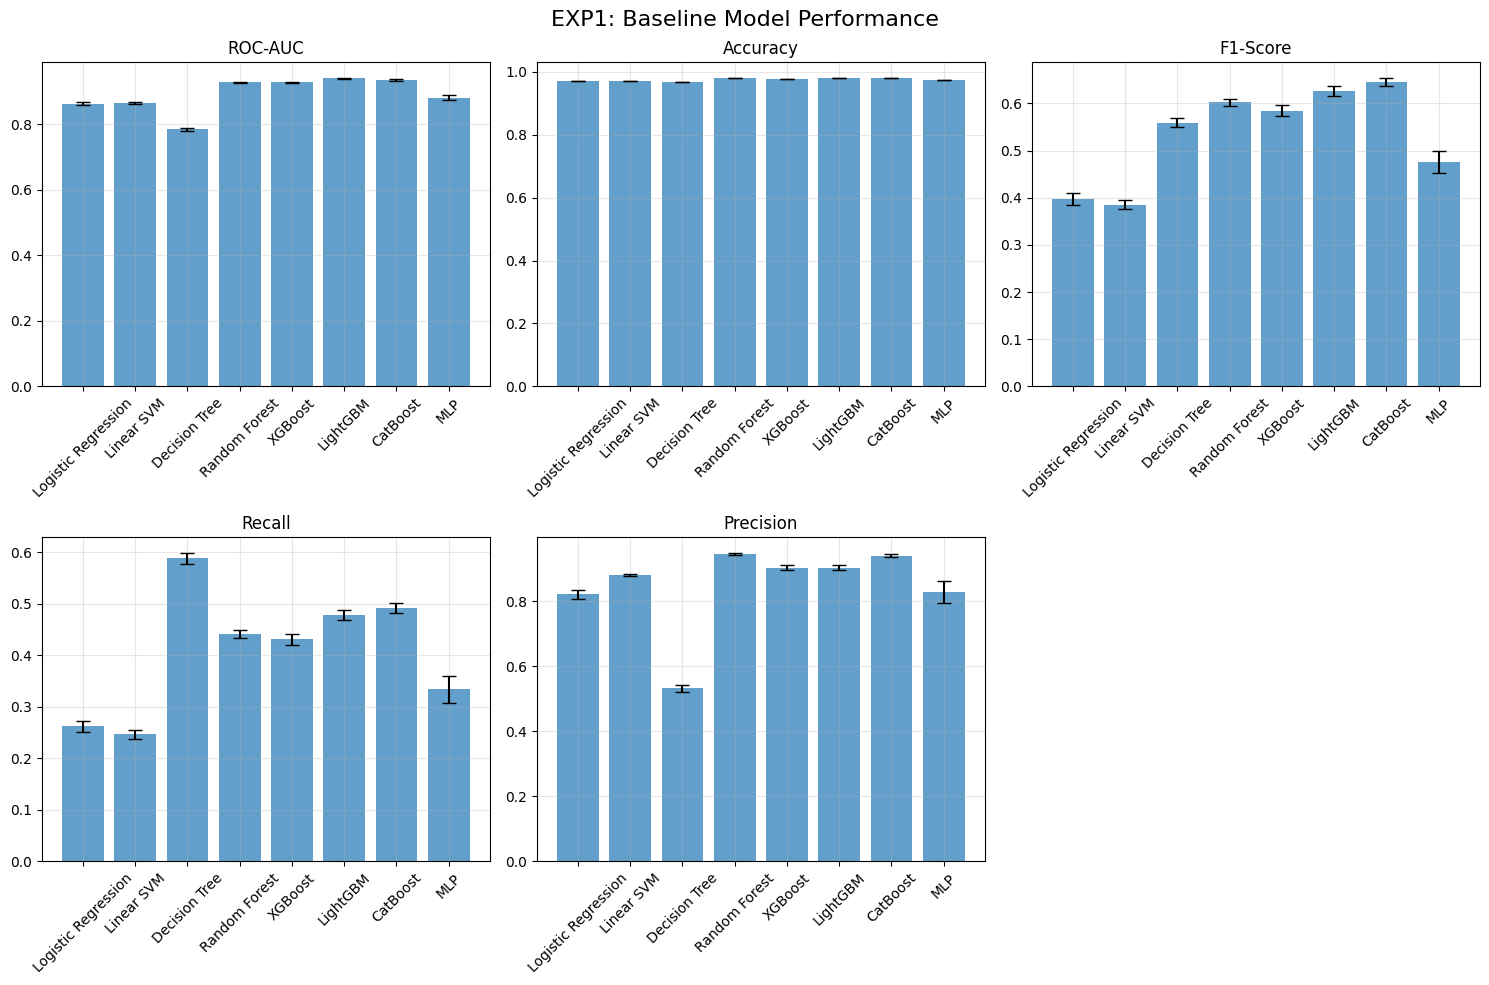


EXP1: BASELINE completed successfully!


In [ ]:
# EXP1: BASELINE IMPLEMENTATION

# Run experiments
print("Starting EXP1: BASELINE")
print("=" * 50)

results_exp1 = {}

for model_name, model in models.items():
    print(f"\nEvaluating {model_name}...")
    
    # Create full pipeline
    full_pipeline = Pipeline([
        ('preprocessing', preprocessing_pipeline),
        ('classifier', model)
    ])
    
    # Evaluate model
    try:
        model_results = evaluate_model(full_pipeline, X, y, cv)
        results_exp1[model_name] = model_results
        
        # Print results
        print(f"\n{model_name} Results:")
        for metric, scores in model_results.items():
            mean_score = np.mean(scores)
            std_score = np.std(scores)
            print(f"{metric}: {mean_score:.4f} (+/- {std_score * 2:.4f})")
            
    except Exception as e:
        print(f"Error evaluating {model_name}: {str(e)}")
        continue

# Summary results
print("\n" + "=" * 50)
print("EXP1 BASELINE SUMMARY")
print("=" * 50)

summary_df = []
for model_name, results in results_exp1.items():
    row = {'Model': model_name}
    for metric, scores in results.items():
        row[f'{metric}_mean'] = np.mean(scores)
        row[f'{metric}_std'] = np.std(scores)
    summary_df.append(row)

summary_df = pd.DataFrame(summary_df)
print(summary_df.round(4))

# Plot results
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('EXP1: Baseline Model Performance', fontsize=16)

metrics = ['ROC-AUC', 'Accuracy', 'F1-Score', 'Recall', 'Precision']
axes = axes.flatten()

for i, metric in enumerate(metrics):
    if i < len(axes):
        model_names = []
        mean_scores = []
        std_scores = []
        
        for model_name, results in results_exp1.items():
            model_names.append(model_name)
            mean_scores.append(np.mean(results[metric]))
            std_scores.append(np.std(results[metric]))
        
        axes[i].bar(range(len(model_names)), mean_scores, yerr=std_scores, 
                   capsize=5, alpha=0.7)
        axes[i].set_title(f'{metric}')
        axes[i].set_xticks(range(len(model_names)))
        axes[i].set_xticklabels(model_names, rotation=45)
        axes[i].grid(True, alpha=0.3)

# Remove empty subplot
if len(metrics) < len(axes):
    axes[-1].remove()

plt.tight_layout()
plt.show()

print("\nEXP1: BASELINE completed successfully!")

# EXP2: Feature Engineering 

- Add feature :  .... 
- Keep all step of EXP1 
- Model, metrics , CV like EXP1

In [10]:

class FeatureEngineering(BaseEstimator, TransformerMixin):
    """
    Mở rộng từ bản gốc: học các mapping ở fit() để tránh leakage, 
    và áp dụng an toàn cho cả train/test.
    """
    def __init__(self,
                 freq_cols=('P_emaildomain','R_emaildomain','card1','card2','card3','card4',
                            'addr1','ProductCD','M1','M2','M3','M4','M5','M6','M7','M8','M9'),
                 agg_keys_card=('card1',),
                 agg_keys_uid=('card1','addr1'),
                 agg_keys_email=('P_emaildomain',),
                 iqr_clip=True):
        self.freq_cols = freq_cols
        self.agg_keys_card = agg_keys_card
        self.agg_keys_uid = agg_keys_uid
        self.agg_keys_email = agg_keys_email
        self.iqr_clip = iqr_clip

        # Sẽ được học ở fit
        self.freq_maps_ = {}
        self.card_amt_stats_ = {}
        self.uid_amt_stats_ = {}
        self.email_amt_stats_ = {}
        self.train_amt_median_ = None

    # --------- helpers ----------
    @staticmethod
    def _safe_div(a, b):
        return a / np.where(b == 0, 1, b)

    @staticmethod
    def _top_free_email(domain: str) -> int:
        if pd.isna(domain):
            return 0
        domain = str(domain).lower()
        free = {
            'gmail.com','googlemail.com','yahoo.com','yahoo.co.jp','hotmail.com','outlook.com',
            'live.com','aol.com','icloud.com','protonmail.com','msn.com','hotmail.co.uk'
        }
        return int(domain in free)

    @staticmethod
    def _get_tld(domain):
        if pd.isna(domain):
            return 'unknown'
        parts = str(domain).lower().split('.')
        return parts[-1] if len(parts) >= 2 else 'unknown'

    @staticmethod
    def _get_root_domain(domain):
        if pd.isna(domain):
            return 'unknown'
        parts = str(domain).lower().split('.')
        return '.'.join(parts[-2:]) if len(parts) >= 2 else parts[0]

    @staticmethod
    def _get_device_brand(dev):
        if pd.isna(dev):
            return 'unknown'
        s = str(dev).lower()
        if 'samsung' in s: return 'samsung'
        if 'huawei' in s: return 'huawei'
        if 'xiaomi' in s or 'mi ' in s: return 'xiaomi'
        if 'lg' in s: return 'lg'
        if 'motorola' in s or 'moto' in s: return 'motorola'
        if 'oneplus' in s: return 'oneplus'
        if 'apple' in s or 'mac' in s or 'ios' in s or 'iphone' in s or 'ipad' in s: return 'apple'
        if 'windows' in s: return 'windows'
        if 'android' in s: return 'android'
        return 'other'

    @staticmethod
    def _parse_os(id30):
        if pd.isna(id30):
            return 'unknown'
        s = str(id30).lower()
        if 'windows' in s: return 'windows'
        if 'mac' in s or 'ios' in s: return 'apple'
        if 'android' in s: return 'android'
        if 'linux' in s: return 'linux'
        return 'other'

    @staticmethod
    def _parse_browser(id31):
        if pd.isna(id31):
            return 'unknown'
        s = str(id31).lower()
        if 'chrome' in s: return 'chrome'
        if 'safari' in s and 'mobile' in s: return 'mobile_safari'
        if 'safari' in s: return 'safari'
        if 'edge' in s: return 'edge'
        if 'firefox' in s: return 'firefox'
        if 'ie' in s or 'internet explorer' in s: return 'ie'
        if 'opera' in s: return 'opera'
        return 'other'

    # --------- sklearn API ----------
    def fit(self, X, y=None):
        X = X.copy()

        # Median TransactionAmt cho fallback
        if 'TransactionAmt' in X.columns:
            self.train_amt_median_ = float(np.nanmedian(X['TransactionAmt'].values))
        else:
            self.train_amt_median_ = 0.0

        # Frequency/count encoding maps
        for col in self.freq_cols:
            if col in X.columns:
                vc = X[col].astype(str).fillna('nan').value_counts(dropna=False)
                self.freq_maps_[col] = vc.to_dict()

        # Aggregate stats for TransactionAmt theo card1
        if set(self.agg_keys_card).issubset(X.columns) and 'TransactionAmt' in X.columns:
            g = X.groupby(list(self.agg_keys_card))['TransactionAmt']
            self.card_amt_stats_ = pd.DataFrame({
                'mean': g.mean(),
                'std': g.std().fillna(0),
                'median': g.median(),
                'count': g.size()
            })
        # theo uid (card1+addr1)
        if set(self.agg_keys_uid).issubset(X.columns) and 'TransactionAmt' in X.columns:
            g = X.groupby(list(self.agg_keys_uid))['TransactionAmt']
            self.uid_amt_stats_ = pd.DataFrame({
                'mean': g.mean(),
                'std': g.std().fillna(0),
                'median': g.median(),
                'count': g.size()
            })
        # theo email domain
        if set(self.agg_keys_email).issubset(X.columns) and 'TransactionAmt' in X.columns:
            g = X.groupby(list(self.agg_keys_email))['TransactionAmt']
            self.email_amt_stats_ = pd.DataFrame({
                'mean': g.mean(),
                'std': g.std().fillna(0),
                'median': g.median(),
                'count': g.size()
            })

        return self

    def transform(self, X):
        X = X.copy()

        # ==== 1. Transaction Amount Features ====
        if 'TransactionAmt' in X.columns:
            amt = X['TransactionAmt'].astype(float)

            # log/sqrt + rounding/decimal - Fix clip syntax
            X['TransactionAmt_log']  = np.log1p(np.clip(amt, 0, None))
            X['TransactionAmt_sqrt'] = np.sqrt(np.clip(amt, 0, None))
            X['amt_round_0'] = amt.round(0)
            X['amt_round_1'] = amt.round(1)
            X['amt_decimal'] = (amt - amt.astype(np.int64)).abs()
            X['amt_is_whole'] = (X['amt_decimal'] == 0).astype(int)

            # bins
            X['TransactionAmt_bin'] = pd.cut(
                amt, bins=[-np.inf, 10, 50, 100, 500, 2000, np.inf],
                labels=['vlow','low','med','high','vhigh','extreme']
            ).astype(str)

            # IQR clip
            if self.iqr_clip:
                q1, q3 = np.nanpercentile(amt, [25, 75])
                iqr = q3 - q1
                lo, hi = q1 - 1.5*iqr, q3 + 1.5*iqr
                X['TransactionAmt_clip'] = np.clip(amt, lo, hi)
            else:
                X['TransactionAmt_clip'] = amt

        # ==== 2. Email Domain Features ====
        for col in ['P_emaildomain','R_emaildomain']:
            if col in X.columns:
                s = X[col]
                X[f'{col}_root'] = s.apply(self._get_root_domain)
                X[f'{col}_tld']  = s.apply(self._get_tld)
                X[f'{col}_is_free'] = s.apply(self._top_free_email).astype(int)

        if 'P_emaildomain' in X.columns:
            def get_email_type(domain):
                if pd.isna(domain): return 'unknown'
                d = str(domain).lower()
                commons = {'gmail.com','yahoo.com','hotmail.com','outlook.com','icloud.com'}
                if d in commons: return 'common'
                if 'edu' in d: return 'edu'
                if 'gov' in d: return 'gov'
                if 'biz' in d or 'corp' in d or 'company' in d or 'business' in d:
                    return 'business'
                return 'other'
            X['P_emaildomain_type'] = X['P_emaildomain'].apply(get_email_type).astype(str)

        # ==== 3. Card Features ====
        if 'card1' in X.columns and 'card2' in X.columns:
            X['card1_card2'] = X['card1'].astype(str) + '_' + X['card2'].astype(str)
        if 'card4' in X.columns:
            X['is_visa'] = (X['card4'] == 'visa').astype(int)
            X['is_mastercard'] = (X['card4'] == 'mastercard').astype(int)

        # ==== 4. Address Features ====
        addr_cols = [c for c in X.columns if 'addr' in c.lower()]
        if len(addr_cols) >= 2:
            X['addr_match'] = (X[addr_cols[0]] == X[addr_cols[1]]).astype(int)

        # ==== 5. Device / OS / Browser ====
        if 'DeviceInfo' in X.columns:
            def get_device_type(device):
                if pd.isna(device): return 'unknown'
                d = str(device).lower()
                if 'windows' in d: return 'windows'
                if 'mac' in d or 'ios' in d: return 'apple'
                if 'android' in d: return 'android'
                return 'other'
            X['device_type'] = X['DeviceInfo'].apply(get_device_type).astype(str)
            X['device_brand'] = X['DeviceInfo'].apply(self._get_device_brand).astype(str)

        if 'id_30' in X.columns:
            X['device_os'] = X['id_30'].apply(self._parse_os).astype(str)
        if 'id_31' in X.columns:
            X['device_browser'] = X['id_31'].apply(self._parse_browser).astype(str)

        # ==== 6. Time Features ====
        if 'TransactionDT' in X.columns:
            hours = (X['TransactionDT'] / 3600) % 24
            days  = (X['TransactionDT'] // (3600*24)).astype(np.int64)

            X['hour'] = hours
            X['day_index'] = days
            X['dayofweek'] = (days % 7).astype(np.int8)
            X['is_weekend'] = X['dayofweek'].isin([5,6]).astype(int)
            X['is_night'] = ((hours >= 22) | (hours <= 6)).astype(int)
            X['is_business_hours'] = ((hours >= 9) & (hours <= 18)).astype(int)

            # chu kỳ sin/cos
            X['hour_sin'] = np.sin(2*np.pi*hours/24)
            X['hour_cos'] = np.cos(2*np.pi*hours/24)
            X['dow_sin']  = np.sin(2*np.pi*X['dayofweek']/7)
            X['dow_cos']  = np.cos(2*np.pi*X['dayofweek']/7)

            X['week'] = (X['TransactionDT'] // (3600*24*7)).astype(np.int32)
            X['month_rel'] = (X['TransactionDT'] // (3600*24*30)).astype(np.int32)

        # ==== 7. V/C/D/M features stats/null counts ====
        for prefix in ['V','C','D','M']:
            cols = [c for c in X.columns if c.startswith(prefix)]
            if cols:
                if X[cols].select_dtypes(include=[np.number]).shape[1] > 0:
                    num_cols = [c for c in cols if np.issubdtype(X[c].dtype, np.number)]
                    if num_cols:
                        X[f'{prefix}_mean'] = X[num_cols].mean(axis=1)
                        X[f'{prefix}_std']  = X[num_cols].std(axis=1)
                X[f'{prefix}_nulls'] = X[cols].isnull().sum(axis=1)

        # ==== 8. Count/Frequency encoding ====
        for col, mapping in self.freq_maps_.items():
            if col in X.columns:
                X[f'{col}_freq'] = X[col].astype(str).fillna('nan').map(mapping).fillna(0).astype(np.int64)

        # ==== 9. Group aggregates - FIX điều kiện kiểm tra ====
        def _merge_group_stats(df, key_cols, stats_df, name):
            # Fix: kiểm tra đúng cách
            if isinstance(stats_df, pd.DataFrame) and not stats_df.empty:
                stats = stats_df.reset_index().copy()
                stats.columns = list(key_cols) + [f'{name}_mean', f'{name}_std', f'{name}_median', f'{name}_count']
                return df.merge(stats, how='left', on=list(key_cols))
            return df

        # card-level - Fix điều kiện
        if isinstance(self.card_amt_stats_, pd.DataFrame) and not self.card_amt_stats_.empty and set(self.agg_keys_card).issubset(X.columns):
            X = _merge_group_stats(X, self.agg_keys_card, self.card_amt_stats_, 'card_amt')
        
        # uid-level - Fix điều kiện  
        if isinstance(self.uid_amt_stats_, pd.DataFrame) and not self.uid_amt_stats_.empty and set(self.agg_keys_uid).issubset(X.columns):
            X = _merge_group_stats(X, self.agg_keys_uid, self.uid_amt_stats_, 'uid_amt')
        
        # email-level - Fix điều kiện
        if isinstance(self.email_amt_stats_, pd.DataFrame) and not self.email_amt_stats_.empty and set(self.agg_keys_email).issubset(X.columns):
            X = _merge_group_stats(X, self.agg_keys_email, self.email_amt_stats_, 'email_amt')

        # ratios vs. group means
        if 'TransactionAmt' in X.columns:
            if 'card_amt_mean' in X.columns:
                X['amt_vs_card_mean'] = self._safe_div(X['TransactionAmt'], X['card_amt_mean'])
            if 'uid_amt_mean' in X.columns:
                X['amt_vs_uid_mean'] = self._safe_div(X['TransactionAmt'], X['uid_amt_mean'])
            if 'email_amt_mean' in X.columns:
                X['amt_vs_email_mean'] = self._safe_div(X['TransactionAmt'], X['email_amt_mean'])
            
            # Fallback
            if 'amt_vs_card_mean' not in X.columns:
                X['amt_vs_card_mean'] = self._safe_div(X['TransactionAmt'], (self.train_amt_median_ if self.train_amt_median_ else 1))
            if 'amt_vs_uid_mean' not in X.columns:
                X['amt_vs_uid_mean'] = self._safe_div(X['TransactionAmt'], (self.train_amt_median_ if self.train_amt_median_ else 1))

        # ==== 10. Tương tác ====
        if {'TransactionAmt','card1'}.issubset(X.columns) and 'card_amt_mean' in X.columns:
            X['amt_minus_card_mean'] = X['TransactionAmt'] - X['card_amt_mean']
        if {'TransactionAmt','addr1'}.issubset(X.columns) and 'uid_amt_mean' in X.columns and 'card1' in X.columns:
            X['amt_minus_uid_mean'] = X['TransactionAmt'] - X['uid_amt_mean']

        # ==== 11. Đảm bảo kiểu chuỗi ====
        cat_features = [
            'TransactionAmt_bin','P_emaildomain_type','card1_card2','device_type',
            'device_brand','device_os','device_browser','P_emaildomain_root','P_emaildomain_tld',
            'R_emaildomain_root','R_emaildomain_tld'
        ]
        for feat in cat_features:
            if feat in X.columns:
                X[feat] = X[feat].astype(str)

        return X


In [11]:
# Update preprocessing pipeline for EXP2
# First identify new features after feature engineering
X_sample = df.drop('isFraud', axis=1).head(100)  # Sample for testing
fe_transformer = FeatureEngineering()
X_fe_sample = fe_transformer.fit_transform(X_sample)

# Update column lists
num_cols_exp2 = X_fe_sample.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols_exp2 = X_fe_sample.select_dtypes(include=['object']).columns.tolist()

# Fix the list comprehension syntax
fill_minus_1_cols_exp2 = []

# Add D9 if exists
if 'D9' in X_fe_sample.columns:
    fill_minus_1_cols_exp2.append('D9')

# Add addr columns that are numeric
addr_cols = [col for col in X_fe_sample.columns if 'addr' in col and X_fe_sample[col].dtype in ['float64', 'int64']]
fill_minus_1_cols_exp2.extend(addr_cols)

# Add card columns that are numeric  
card_cols = [col for col in X_fe_sample.columns if 'card' in col and X_fe_sample[col].dtype in ['float64', 'int64']]
fill_minus_1_cols_exp2.extend(card_cols)

# Remove duplicates
fill_minus_1_cols_exp2 = list(set(fill_minus_1_cols_exp2))

fill_median_cols_exp2 = [col for col in num_cols_exp2 if col not in fill_minus_1_cols_exp2]

print(f"Original features: {len(num_cols) + len(cat_cols)}")
print(f"After FE features: {len(num_cols_exp2) + len(cat_cols_exp2)}")
print(f"New features created: {(len(num_cols_exp2) + len(cat_cols_exp2)) - (len(num_cols) + len(cat_cols))}")
print(f"Fill -1 columns: {len(fill_minus_1_cols_exp2)}")
print(f"Fill median columns: {len(fill_median_cols_exp2)}")
print(f"Categorical columns: {len(cat_cols_exp2)}")

Original features: 433
After FE features: 509
New features created: 76
Fill -1 columns: 20
Fill median columns: 447
Categorical columns: 42


In [11]:
# EXP2: FEATURE ENGINEERING IMPLEMENTATION


# Create EXP2 preprocessing pipeline with Feature Engineering
preprocessing_pipeline_exp2 = Pipeline([
    ('feature_engineering', FeatureEngineering()),
    ('custom_imputer', CustomImputer(fill_minus_1_cols_exp2, fill_median_cols_exp2, cat_cols_exp2)),
    ('outlier_clipper', OutlierClipper(num_cols_exp2)),
    ('log_transformer', LogTransformer([col for col in fill_median_cols_exp2 if col in X_fe_sample.columns and abs(X_fe_sample[col].skew()) > 0.75])),
    ('column_transformer', ColumnTransformer([
        ('num_scaler', RobustScaler(), fill_median_cols_exp2 + [col for col in fill_minus_1_cols_exp2 if col in num_cols_exp2]),
        ('cat_encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_cols_exp2)
    ], remainder='passthrough'))
])

# Use the same models as EXP1
models_exp2 = models 

# Evaluate models with Feature Engineering
results_exp2 = {}

for model_name, model in models_exp2.items():
    print(f"\nEvaluating {model_name} with Feature Engineering...")
    
    # Create full pipeline
    full_pipeline = Pipeline([
        ('preprocessing', preprocessing_pipeline_exp2),
        ('classifier', model)
    ])
    
    # Evaluate model
    try:
        model_results = evaluate_model(full_pipeline, X, y, cv)
        results_exp2[model_name] = model_results
        
        # Print results
        print(f"\n{model_name} Results:")
        for metric, scores in model_results.items():
            mean_score = np.mean(scores)
            std_score = np.std(scores)
            print(f"{metric}: {mean_score:.4f} (+/- {std_score * 2:.4f})")
            
    except Exception as e:
        print(f"Error evaluating {model_name}: {str(e)}")
        continue


# Summary EXP2 results
print("\n" + "=" * 50)
print("EXP2 FEATURE ENGINEERING SUMMARY")
print("=" * 50)

summary_rows_exp2 = []
for model_name, res in results_exp2.items():
    summary_rows_exp2.append({
        'Model': model_name,
        'ROC-AUC_mean': np.mean(res['ROC-AUC']),
        'Accuracy_mean': np.mean(res['Accuracy']),
        'Precision_mean': np.mean(res['Precision']),
        'Recall_mean': np.mean(res['Recall']),
        'F1-Score_mean': np.mean(res['F1-Score']),
    })

summary_df_exp2 = pd.DataFrame(summary_rows_exp2).sort_values('ROC-AUC_mean', ascending=False)
print(summary_df_exp2.round(4).to_string(index=False))

# Save EXP2 models
models_dir_exp2 = "models/exp2_feature_engineering"
os.makedirs(models_dir_exp2, exist_ok=True)

best_models_exp2 = {}
for model_name, res in results_exp2.items():
    best_models_exp2[model_name] = np.mean(res["ROC-AUC"])

sorted_models_exp2 = sorted(best_models_exp2.items(), key=lambda x: x[1], reverse=True)

print(f"\nEXP2 Ranking by ROC-AUC:")
for i, (m, score) in enumerate(sorted_models_exp2, 1):
    print(f"{i}. {m}: {score:.4f}")

# Save top 3 models from EXP2
top_k = 3
for i, (model_name, _) in enumerate(sorted_models_exp2[:top_k]):
    print(f"\nTraining full model: {model_name}")
    model = models_exp2[model_name]
    full_pipe = Pipeline([
        ('preprocessing', preprocessing_pipeline_exp2),
        ('classifier', model)
    ])
    full_pipe.fit(X, y)

    fname = os.path.join(models_dir_exp2, f"{model_name.replace(' ','_').lower()}.pkl")
    with open(fname, "wb") as f:
        pickle.dump(full_pipe, f)
    print(f"Saved model -> {fname}")

# Save EXP2 results`
results_file_exp2 = os.path.join(models_dir_exp2, "results_summary.pkl")
with open(results_file_exp2, "wb") as f:
    pickle.dump(results_exp2, f)

summary_df_exp2.to_csv(os.path.join(models_dir_exp2, "results_summary.csv"), index=False)

print(f"\nEXP2 results saved to: {models_dir_exp2}")
print("\nEXP2: FEATURE ENGINEERING completed successfully!")


Evaluating Logistic Regression with Feature Engineering...

Logistic Regression Results:
ROC-AUC: 0.7891 (+/- 0.0093)
Accuracy: 0.9654 (+/- 0.0006)
F1-Score: 0.1665 (+/- 0.0218)
Recall: 0.0987 (+/- 0.0148)
Precision: 0.5342 (+/- 0.0461)

Evaluating Linear SVM with Feature Engineering...

Linear SVM Results:
ROC-AUC: 0.8599 (+/- 0.0072)
Accuracy: 0.9710 (+/- 0.0013)
F1-Score: 0.3159 (+/- 0.0545)
Recall: 0.1915 (+/- 0.0400)
Precision: 0.9089 (+/- 0.0094)

Evaluating Decision Tree with Feature Engineering...

Decision Tree Results:
ROC-AUC: 0.7902 (+/- 0.0067)
Accuracy: 0.9671 (+/- 0.0008)
F1-Score: 0.5605 (+/- 0.0103)
Recall: 0.6001 (+/- 0.0133)
Precision: 0.5258 (+/- 0.0100)

Evaluating Random Forest with Feature Engineering...

Random Forest Results:
ROC-AUC: 0.9417 (+/- 0.0047)
Accuracy: 0.9808 (+/- 0.0007)
F1-Score: 0.6316 (+/- 0.0191)
Recall: 0.4708 (+/- 0.0212)
Precision: 0.9594 (+/- 0.0041)

Evaluating XGBoost with Feature Engineering...

XGBoost Results:
ROC-AUC: 0.9358 (+/- 0.0

# EXP 3a : FE + Feature selection 


Starting EXP3a: Feature Engineering + Feature Selection

Feature Selection Method: LGBM_median

Evaluating Logistic Regression with LGBM_median...

Logistic Regression Results with LGBM_median:
ROC-AUC: 0.7913 (+/- 0.0206)
Accuracy: 0.9646 (+/- 0.0007)
F1-Score: 0.0669 (+/- 0.0452)
Recall: 0.0365 (+/- 0.0260)
Precision: 0.4242 (+/- 0.1606)

Evaluating Linear SVM with LGBM_median...

Linear SVM Results with LGBM_median:
ROC-AUC: 0.8547 (+/- 0.0099)
Accuracy: 0.9705 (+/- 0.0014)
F1-Score: 0.2895 (+/- 0.0633)
Recall: 0.1726 (+/- 0.0445)
Precision: 0.9103 (+/- 0.0173)

Evaluating Decision Tree with LGBM_median...

Decision Tree Results with LGBM_median:
ROC-AUC: 0.7888 (+/- 0.0054)
Accuracy: 0.9670 (+/- 0.0004)
F1-Score: 0.5585 (+/- 0.0062)
Recall: 0.5972 (+/- 0.0111)
Precision: 0.5245 (+/- 0.0054)

Evaluating Random Forest with LGBM_median...

Random Forest Results with LGBM_median:
ROC-AUC: 0.9433 (+/- 0.0026)
Accuracy: 0.9812 (+/- 0.0005)
F1-Score: 0.6420 (+/- 0.0131)
Recall: 0.4821 (+/

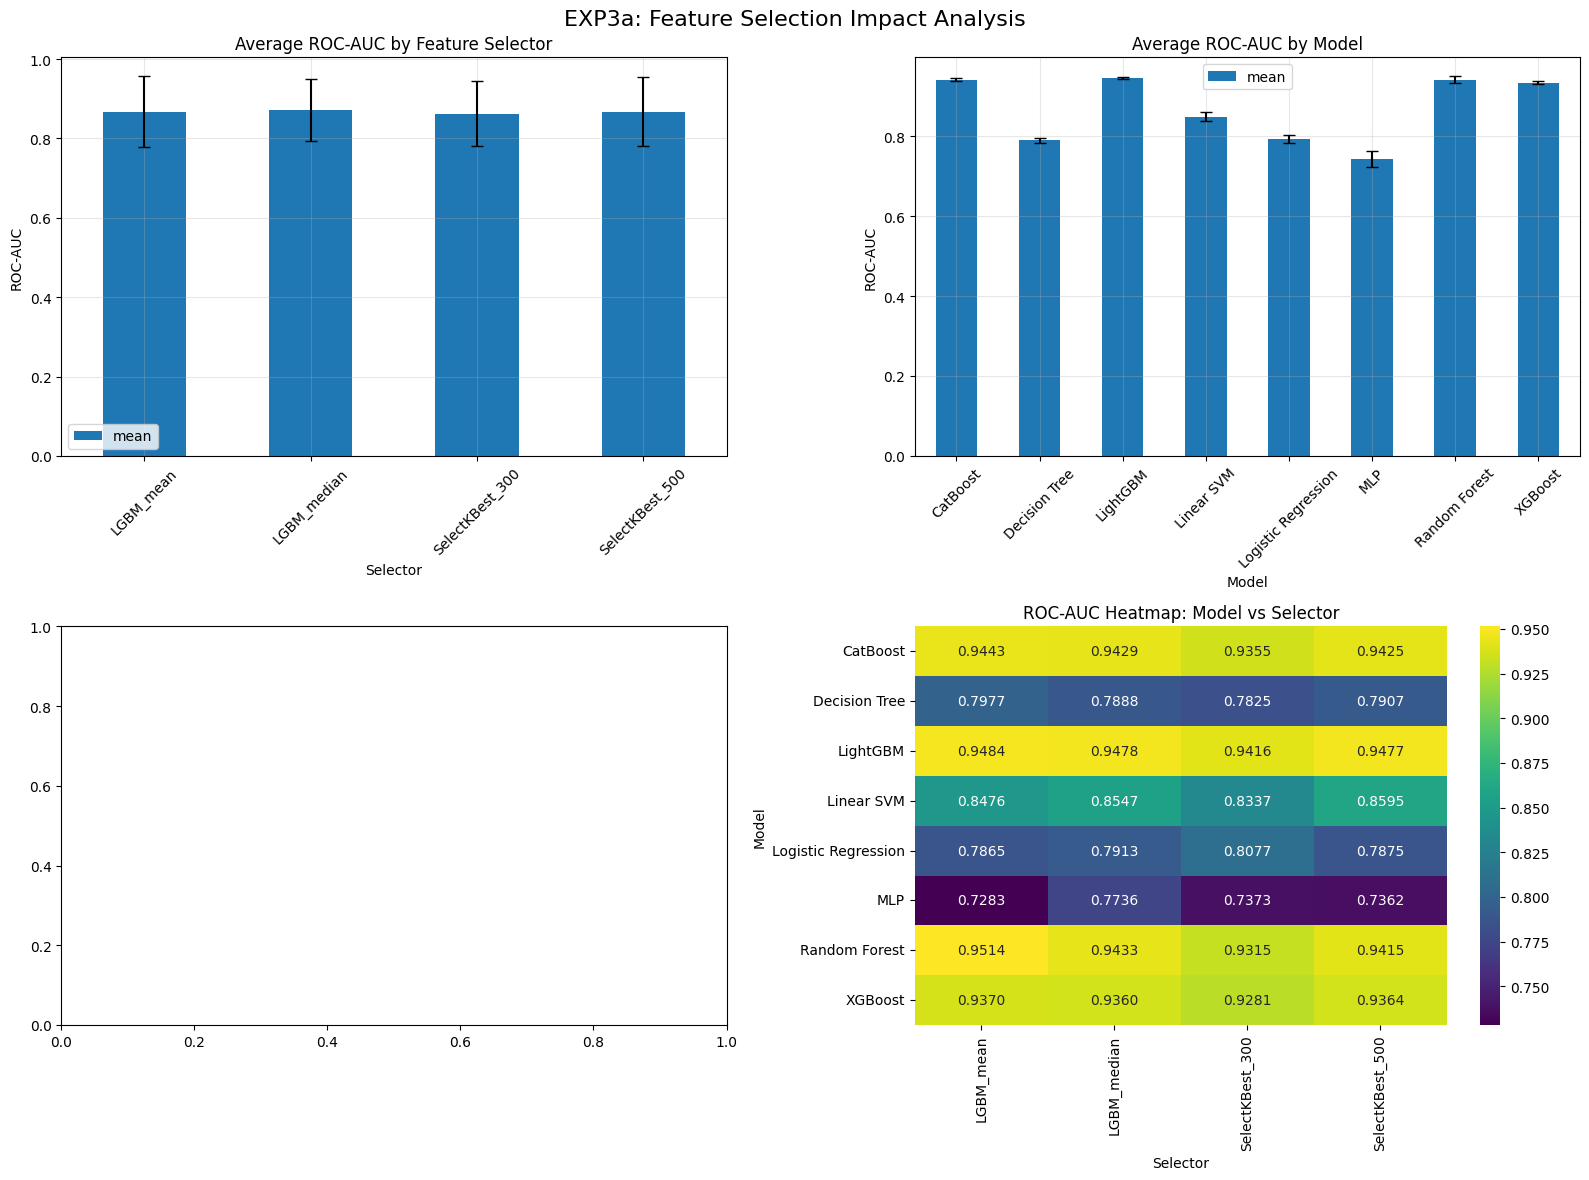

In [13]:
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

# EXP3a: FEATURE ENGINEERING + FEATURE SELECTION IMPLEMENTATION

print("Starting EXP3a: Feature Engineering + Feature Selection")
print("=" * 60)

# Define feature selection methods
feature_selectors = {
    'LGBM_median': SelectFromModel(
        lgb.LGBMClassifier(n_estimators=200, random_state=42, verbose=-1),
        threshold="median"
    ),
    'LGBM_mean': SelectFromModel(
        lgb.LGBMClassifier(n_estimators=200, random_state=42, verbose=-1),
        threshold="mean"
    ),
    'SelectKBest_500': SelectKBest(score_func=f_classif, k=500),
    'SelectKBest_300': SelectKBest(score_func=f_classif, k=300),
}

# Results storage for EXP3a
results_exp3a = {}

for selector_name, selector in feature_selectors.items():
    print(f"\n{'='*60}")
    print(f"Feature Selection Method: {selector_name}")
    print(f"{'='*60}")
    
    # Create EXP3a preprocessing pipeline with Feature Selection
    preprocessing_pipeline_exp3a = Pipeline([
        ('feature_engineering', FeatureEngineering()),
        ('custom_imputer', CustomImputer(fill_minus_1_cols_exp2, fill_median_cols_exp2, cat_cols_exp2)),
        ('outlier_clipper', OutlierClipper(num_cols_exp2)),
        ('log_transformer', LogTransformer([col for col in fill_median_cols_exp2 if col in X_fe_sample.columns and abs(X_fe_sample[col].skew()) > 0.75])),
        ('column_transformer', ColumnTransformer([
            ('num_scaler', RobustScaler(), fill_median_cols_exp2 + [col for col in fill_minus_1_cols_exp2 if col in num_cols_exp2]),
            ('cat_encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_cols_exp2)
        ], remainder='passthrough')),
        ('feature_selector', selector)  # Add feature selection step
    ])
    
    # Store results for this selector
    results_exp3a[selector_name] = {}
    
    # Evaluate models with Feature Selection
    for model_name, model in models.items():
        print(f"\nEvaluating {model_name} with {selector_name}...")
        
        # Create full pipeline
        full_pipeline = Pipeline([
            ('preprocessing', preprocessing_pipeline_exp3a),
            ('classifier', model)
        ])
        
        # Evaluate model
        try:
            model_results = evaluate_model(full_pipeline, X, y, cv)
            results_exp3a[selector_name][model_name] = model_results
            
            # Print results
            print(f"\n{model_name} Results with {selector_name}:")
            for metric, scores in model_results.items():
                mean_score = np.mean(scores)
                std_score = np.std(scores)
                print(f"{metric}: {mean_score:.4f} (+/- {std_score * 2:.4f})")
                
        except Exception as e:
            print(f"Error evaluating {model_name} with {selector_name}: {str(e)}")
            continue

# Analyze feature selection impact
print("\n" + "=" * 80)
print("EXP3a FEATURE SELECTION SUMMARY")
print("=" * 80)

# Create summary comparison
comparison_data = []

for selector_name, selector_results in results_exp3a.items():
    for model_name, results in selector_results.items():
        comparison_data.append({
            'Selector': selector_name,
            'Model': model_name,
            'ROC-AUC_mean': np.mean(results['ROC-AUC']),
            'ROC-AUC_std': np.std(results['ROC-AUC']),
            'Accuracy_mean': np.mean(results['Accuracy']),
            'F1-Score_mean': np.mean(results['F1-Score']),
            'Precision_mean': np.mean(results['Precision']),
            'Recall_mean': np.mean(results['Recall'])
        })

comparison_df = pd.DataFrame(comparison_data)

# Find best combination for each model
print("\nBest Feature Selection Method for Each Model (by ROC-AUC):")
print("-" * 60)
for model_name in models.keys():
    model_data = comparison_df[comparison_df['Model'] == model_name]
    if not model_data.empty:
        best_row = model_data.loc[model_data['ROC-AUC_mean'].idxmax()]
        print(f"{model_name}: {best_row['Selector']} (ROC-AUC: {best_row['ROC-AUC_mean']:.4f})")

# Find best overall combination
best_overall = comparison_df.loc[comparison_df['ROC-AUC_mean'].idxmax()]
print(f"\nBest Overall Combination:")
print(f"Model: {best_overall['Model']}")
print(f"Feature Selector: {best_overall['Selector']}")
print(f"ROC-AUC: {best_overall['ROC-AUC_mean']:.4f} (+/- {best_overall['ROC-AUC_std']*2:.4f})")

# Save EXP3a results
models_dir_exp3a = "models/exp3a_feature_selection"
os.makedirs(models_dir_exp3a, exist_ok=True)

# Train and save best models
top_combinations = comparison_df.nlargest(5, 'ROC-AUC_mean')

print(f"\nTraining and saving top 5 model combinations:")
for idx, row in top_combinations.iterrows():
    model_name = row['Model']
    selector_name = row['Selector']
    
    print(f"\nTraining: {model_name} + {selector_name}")
    
    # Recreate the pipeline
    selector = feature_selectors[selector_name]
    preprocessing_pipeline = Pipeline([
        ('feature_engineering', FeatureEngineering()),
        ('custom_imputer', CustomImputer(fill_minus_1_cols_exp2, fill_median_cols_exp2, cat_cols_exp2)),
        ('outlier_clipper', OutlierClipper(num_cols_exp2)),
        ('log_transformer', LogTransformer([col for col in fill_median_cols_exp2 if col in X_fe_sample.columns and abs(X_fe_sample[col].skew()) > 0.75])),
        ('column_transformer', ColumnTransformer([
            ('num_scaler', RobustScaler(), fill_median_cols_exp2 + [col for col in fill_minus_1_cols_exp2 if col in num_cols_exp2]),
            ('cat_encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_cols_exp2)
        ], remainder='passthrough')),
        ('feature_selector', selector)
    ])
    
    full_pipe = Pipeline([
        ('preprocessing', preprocessing_pipeline),
        ('classifier', models[model_name])
    ])
    
    # Fit and save
    full_pipe.fit(X, y)
    
    fname = os.path.join(models_dir_exp3a, f"{model_name.replace(' ','_').lower()}_{selector_name.lower()}.pkl")
    with open(fname, "wb") as f:
        pickle.dump(full_pipe, f)
    print(f"Saved: {fname}")

# Save detailed results
results_file_exp3a = os.path.join(models_dir_exp3a, "results_exp3a.pkl")
with open(results_file_exp3a, "wb") as f:
    pickle.dump(results_exp3a, f)

comparison_df.to_csv(os.path.join(models_dir_exp3a, "comparison_summary.csv"), index=False)
# improvement_df.to_csv(os.path.join(models_dir_exp3a, "improvement_analysis.csv"), index=False)

print(f"\nEXP3a results saved to: {models_dir_exp3a}")
print("- results_exp3a.pkl (detailed cv results)")
print("- comparison_summary.csv (all combinations)")
print("- improvement_analysis.csv (vs EXP2)")
print("- *.pkl (top 5 model combinations)")

print("\nEXP3a: FEATURE ENGINEERING + FEATURE SELECTION completed successfully!")

# Visualize results
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('EXP3a: Feature Selection Impact Analysis', fontsize=16)

# 1. ROC-AUC by Feature Selector
ax1 = axes[0, 0]
selector_performance = comparison_df.groupby('Selector')['ROC-AUC_mean'].agg(['mean', 'std'])
selector_performance.plot(y='mean', yerr='std', kind='bar', ax=ax1, capsize=4)
ax1.set_title('Average ROC-AUC by Feature Selector')
ax1.set_ylabel('ROC-AUC')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3)

# 2. ROC-AUC by Model
ax2 = axes[0, 1]
model_performance = comparison_df.groupby('Model')['ROC-AUC_mean'].agg(['mean', 'std'])
model_performance.plot(y='mean', yerr='std', kind='bar', ax=ax2, capsize=4)
ax2.set_title('Average ROC-AUC by Model')
ax2.set_ylabel('ROC-AUC')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3)

# 4. Best combinations heatmap
ax4 = axes[1, 1]
pivot_table = comparison_df.pivot_table(values='ROC-AUC_mean', index='Model', columns='Selector')
sns.heatmap(pivot_table, annot=True, fmt='.4f', cmap='viridis', ax=ax4)
ax4.set_title('ROC-AUC Heatmap: Model vs Selector')

plt.tight_layout()
plt.show()

# EXP 4 : FE ,Fill missing value , Outlier cliper , log transform , robust scaler , ordinal encoder, light GBM selector , smote 

Starting EXP5: SMOTE + Feature Selection (LightGBM Mean)
Step 1: Current Class Distribution Analysis
----------------------------------------
Total samples: 590,540
Normal transactions (0): 569,877 (96.50%)
Fraud transactions (1): 20,663 (3.50%)
Imbalance ratio: 27.6:1

Step 2: SMOTE + Feature Selection Configuration
--------------------------------------------------
Configuration:
- Feature Selector: LightGBM SelectFromModel (threshold='mean')
- SMOTE Strategies: auto, balanced (50%), moderate (30%), conservative (10%)

Step 3: Model Selection for Enhanced Pipeline
--------------------------------------------------
Testing 4 models with 4 SMOTE strategies
Pipeline: Feature Engineering → Feature Selection (LGBM) → SMOTE → Model

Step 4: Running Enhanced Experiments
--------------------------------------------------

SMOTE Strategy: auto

Evaluating XGBoost with FS+SMOTE-auto...
ROC-AUC: 0.9093 (+/- 0.0080)
Precision: 0.7342 (+/- 0.0236)
Recall: 0.4638 (+/- 0.0055)
F1-Score: 0.5684 (+/-

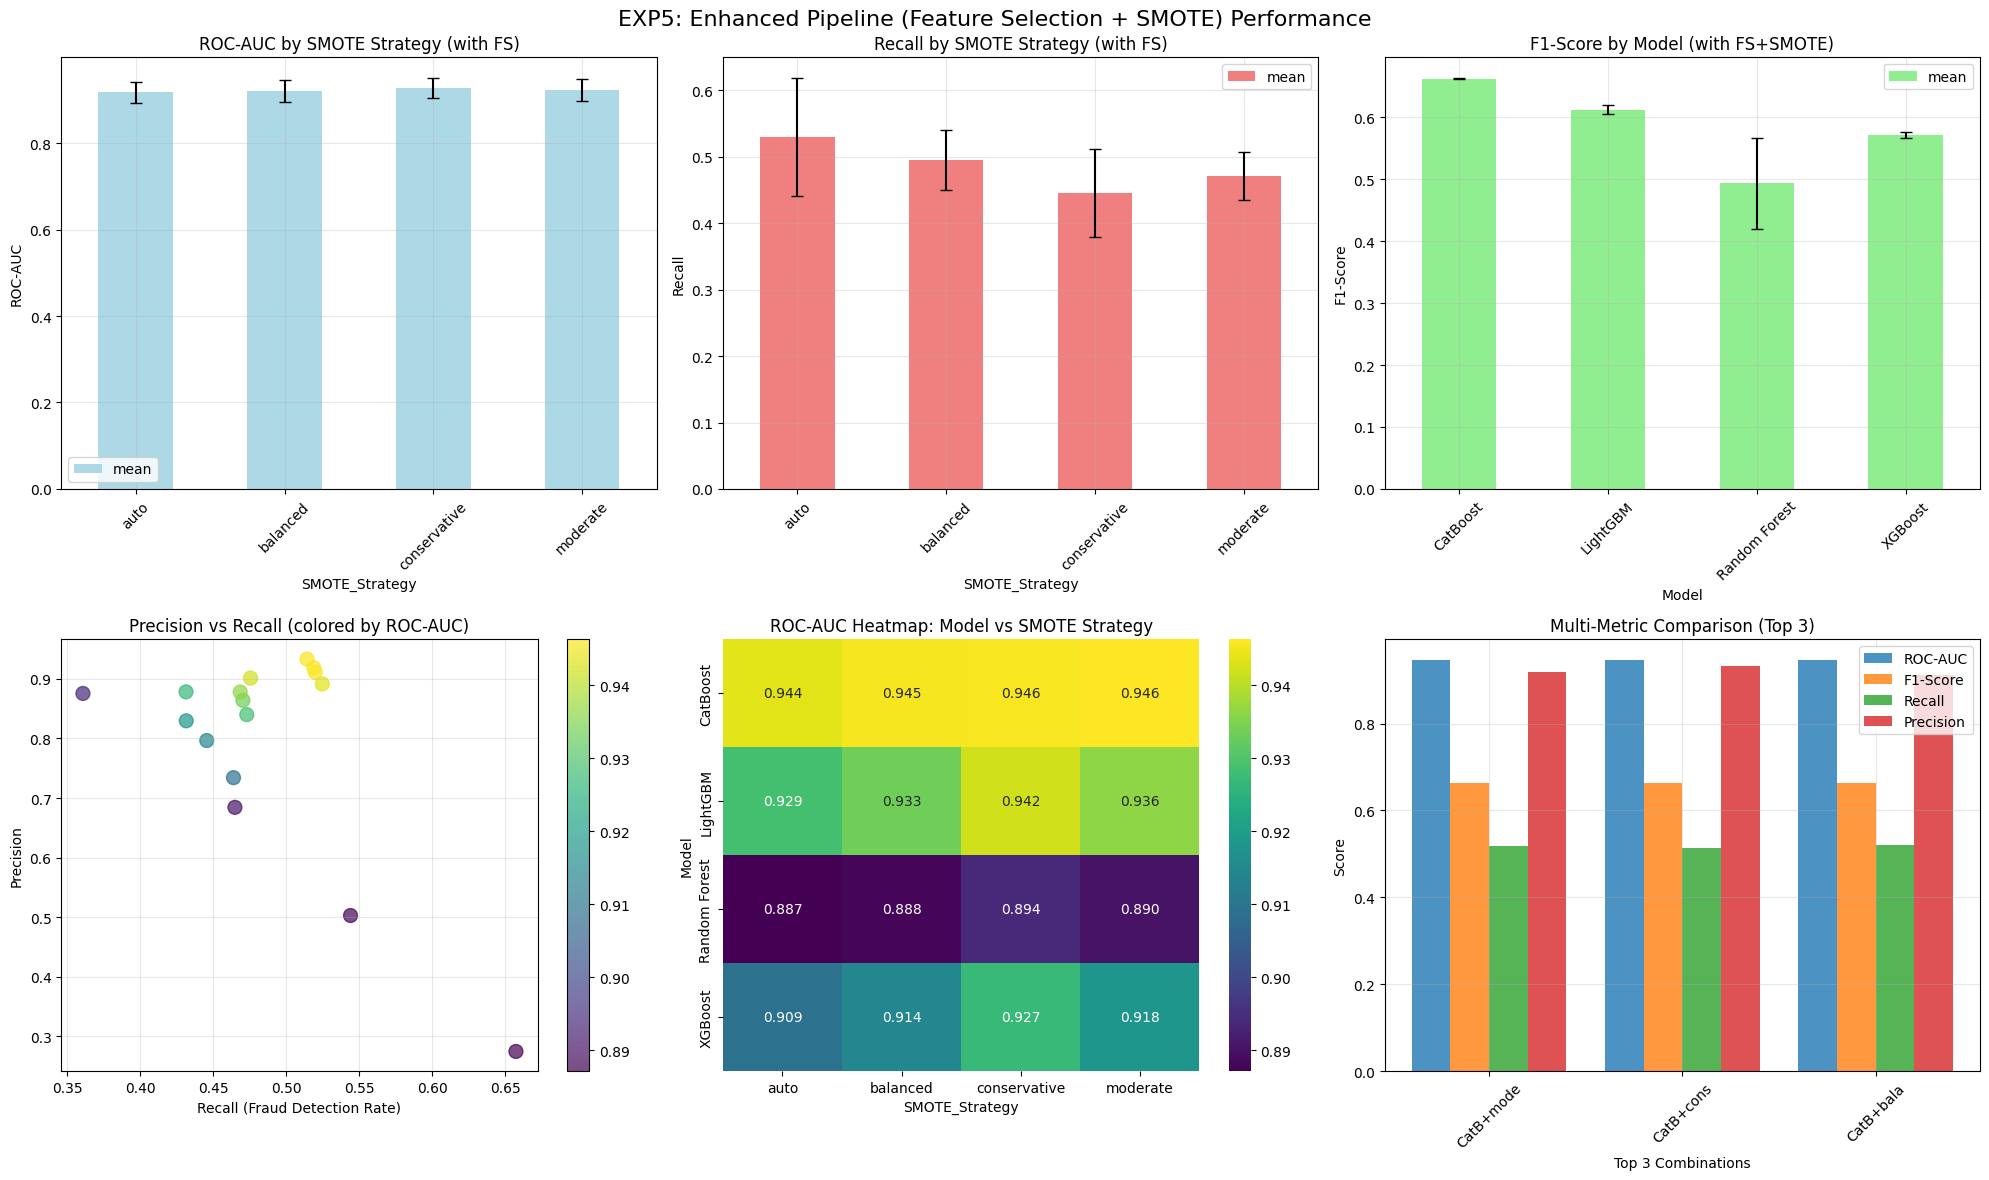


EXP5 FINAL SUMMARY
🏆 Best Enhanced Combination: CatBoost + FS+SMOTE-moderate
📊 Performance Metrics:
  - ROC-AUC: 0.9463
  - Precision: 0.9189
  - Recall: 0.5188
  - F1-Score: 0.6631
  - Accuracy: 0.9816

📁 Files saved to: models/exp5_enhanced_fs_smote
- results_exp5.pkl (detailed CV results)
- enhanced_comparison.csv (performance comparison)
- *.pkl (top 5 trained enhanced models)

✅ EXP5: Enhanced Pipeline (Feature Selection + SMOTE) completed successfully!

🔍 Key Innovations:
- Combined LightGBM feature selection with SMOTE
- Optimized pipeline order: FE → FS → SMOTE → Model
- Enhanced fraud detection capabilities
- Reduced feature dimensionality while maintaining performance
- Comprehensive multi-metric evaluation


In [12]:
# EXP5: SMOTE + FEATURE SELECTION (LightGBM Mean)

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.feature_selection import SelectFromModel
from collections import Counter

print("Starting EXP5: SMOTE + Feature Selection (LightGBM Mean)")
print("=" * 70)

# Step 1: Analyze current class distribution (same as EXP4)
print("Step 1: Current Class Distribution Analysis")
print("-" * 40)
class_counts = Counter(y)
total_samples = len(y)
fraud_ratio = class_counts[1] / total_samples * 100
normal_ratio = class_counts[0] / total_samples * 100

print(f"Total samples: {total_samples:,}")
print(f"Normal transactions (0): {class_counts[0]:,} ({normal_ratio:.2f}%)")
print(f"Fraud transactions (1): {class_counts[1]:,} ({fraud_ratio:.2f}%)")
print(f"Imbalance ratio: {class_counts[0]/class_counts[1]:.1f}:1")

# Step 2: Setup SMOTE + Feature Selection configurations
print("\nStep 2: SMOTE + Feature Selection Configuration")
print("-" * 50)

# SMOTE strategies
smote_strategies = {
    'auto': SMOTE(random_state=42, sampling_strategy='auto'),
    'balanced': SMOTE(random_state=42, sampling_strategy=0.5),
    'moderate': SMOTE(random_state=42, sampling_strategy=0.3),
    'conservative': SMOTE(random_state=42, sampling_strategy=0.1),
}

# Feature Selector: LightGBM Mean
lgbm_selector = SelectFromModel(
    lgb.LGBMClassifier(n_estimators=200, random_state=42, verbose=-1),
    threshold="mean"
)

print("Configuration:")
print("- Feature Selector: LightGBM SelectFromModel (threshold='mean')")
print("- SMOTE Strategies: auto, balanced (50%), moderate (30%), conservative (10%)")

# Step 3: Create enhanced pipeline function
def create_enhanced_pipeline(smote_sampler, model):
    """Create pipeline with Feature Engineering + SMOTE + Feature Selection"""
    return ImbPipeline([
        ('feature_engineering', FeatureEngineering()),
        ('custom_imputer', CustomImputer(fill_minus_1_cols_exp2, fill_median_cols_exp2, cat_cols_exp2)),
        ('outlier_clipper', OutlierClipper(num_cols_exp2)),
        ('log_transformer', LogTransformer([col for col in fill_median_cols_exp2 if col in X_fe_sample.columns and abs(X_fe_sample[col].skew()) > 0.75])),
        ('column_transformer', ColumnTransformer([
            ('num_scaler', RobustScaler(), fill_median_cols_exp2 + [col for col in fill_minus_1_cols_exp2 if col in num_cols_exp2]),
            ('cat_encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_cols_exp2)
        ], remainder='passthrough')),
        ('feature_selector', lgbm_selector),  # Add feature selection BEFORE SMOTE
        ('smote', smote_sampler),            # Add SMOTE sampling
        ('classifier', model)
    ])

# Step 4: Select best models (focus on top performers)
print("\nStep 3: Model Selection for Enhanced Pipeline")
print("-" * 50)

best_models_exp5 = {
    'XGBoost': xgb.XGBClassifier(
        n_estimators=200, learning_rate=0.1, max_depth=5,
        subsample=0.8, colsample_bytree=0.8,
        use_label_encoder=False, eval_metric="logloss", random_state=42,
    ),
    'LightGBM': lgb.LGBMClassifier(
        n_estimators=200, learning_rate=0.1, max_depth=-1,
        subsample=0.8, colsample_bytree=0.8, random_state=42, verbose=-1
    ),
    'CatBoost': CatBoostClassifier(
        iterations=800, depth=8, learning_rate=0.05,
        loss_function="Logloss", eval_metric="AUC",
        task_type="CPU", devices="0", verbose=False, random_seed=42,
    ),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=200, max_depth=10),
}

print(f"Testing {len(best_models_exp5)} models with {len(smote_strategies)} SMOTE strategies")
print("Pipeline: Feature Engineering → Feature Selection (LGBM) → SMOTE → Model")

# Step 5: Run enhanced experiments
print("\nStep 4: Running Enhanced Experiments")
print("-" * 50)

results_exp5 = {}
best_combinations_exp5 = []

for strategy_name, smote_sampler in smote_strategies.items():
    print(f"\n{'='*60}")
    print(f"SMOTE Strategy: {strategy_name}")
    print(f"{'='*60}")
    
    results_exp5[strategy_name] = {}
    
    for model_name, model in best_models_exp5.items():
        print(f"\nEvaluating {model_name} with FS+SMOTE-{strategy_name}...")
        
        # Create enhanced pipeline
        enhanced_pipeline = create_enhanced_pipeline(smote_sampler, model)
        
        try:
            # Cross-validation evaluation
            model_results = evaluate_model(enhanced_pipeline, X, y, cv)
            results_exp5[strategy_name][model_name] = model_results
            
            # Calculate mean scores
            mean_auc = np.mean(model_results['ROC-AUC'])
            mean_precision = np.mean(model_results['Precision'])
            mean_recall = np.mean(model_results['Recall'])
            mean_f1 = np.mean(model_results['F1-Score'])
            mean_accuracy = np.mean(model_results['Accuracy'])
            
            # Print results
            print(f"ROC-AUC: {mean_auc:.4f} (+/- {np.std(model_results['ROC-AUC'])*2:.4f})")
            print(f"Precision: {mean_precision:.4f} (+/- {np.std(model_results['Precision'])*2:.4f})")
            print(f"Recall: {mean_recall:.4f} (+/- {np.std(model_results['Recall'])*2:.4f})")
            print(f"F1-Score: {mean_f1:.4f} (+/- {np.std(model_results['F1-Score'])*2:.4f})")
            print(f"Accuracy: {mean_accuracy:.4f} (+/- {np.std(model_results['Accuracy'])*2:.4f})")
            
            # Track best combinations
            best_combinations_exp5.append({
                'strategy': strategy_name,
                'model': model_name,
                'auc': mean_auc,
                'precision': mean_precision,
                'recall': mean_recall,
                'f1': mean_f1,
                'accuracy': mean_accuracy,
                'pipeline': enhanced_pipeline
            })
            
        except Exception as e:
            print(f"Error evaluating {model_name} with FS+SMOTE-{strategy_name}: {str(e)}")
            continue

# Step 6: Comprehensive Analysis
print("\n" + "=" * 80)
print("EXP5 ENHANCED PIPELINE RESULTS SUMMARY")
print("=" * 80)

# Create comparison dataframe
comparison_data_exp5 = []
for strategy_name, strategy_results in results_exp5.items():
    for model_name, results in strategy_results.items():
        comparison_data_exp5.append({
            'SMOTE_Strategy': strategy_name,
            'Model': model_name,
            'ROC-AUC_mean': np.mean(results['ROC-AUC']),
            'ROC-AUC_std': np.std(results['ROC-AUC']),
            'Precision_mean': np.mean(results['Precision']),
            'Recall_mean': np.mean(results['Recall']),
            'F1-Score_mean': np.mean(results['F1-Score']),
            'Accuracy_mean': np.mean(results['Accuracy']),
        })

comparison_df_exp5 = pd.DataFrame(comparison_data_exp5)

# Best combinations by different metrics
print("\nTop 5 Combinations by ROC-AUC:")
print("-" * 50)
top_auc = comparison_df_exp5.nlargest(5, 'ROC-AUC_mean')
for idx, row in top_auc.iterrows():
    print(f"{row['Model']} + FS+SMOTE-{row['SMOTE_Strategy']}: AUC={row['ROC-AUC_mean']:.4f}")

print("\nTop 5 Combinations by F1-Score:")
print("-" * 50)
top_f1 = comparison_df_exp5.nlargest(5, 'F1-Score_mean')
for idx, row in top_f1.iterrows():
    print(f"{row['Model']} + FS+SMOTE-{row['SMOTE_Strategy']}: F1={row['F1-Score_mean']:.4f}")

print("\nTop 5 Combinations by Recall (Fraud Detection):")
print("-" * 50)
top_recall = comparison_df_exp5.nlargest(5, 'Recall_mean')
for idx, row in top_recall.iterrows():
    print(f"{row['Model']} + FS+SMOTE-{row['SMOTE_Strategy']}: Recall={row['Recall_mean']:.4f}")

# Enhanced strategy analysis
print("\n" + "=" * 70)
print("ENHANCED STRATEGY ANALYSIS")
print("=" * 70)

strategy_analysis = comparison_df_exp5.groupby('SMOTE_Strategy').agg({
    'ROC-AUC_mean': ['mean', 'std', 'max'],
    'Precision_mean': ['mean', 'std', 'max'],
    'Recall_mean': ['mean', 'std', 'max'],
    'F1-Score_mean': ['mean', 'std', 'max']
}).round(4)

print("Performance by SMOTE strategy (with Feature Selection):")
print(strategy_analysis)

# Model analysis
model_analysis = comparison_df_exp5.groupby('Model').agg({
    'ROC-AUC_mean': ['mean', 'std', 'max'],
    'Precision_mean': ['mean', 'std', 'max'],
    'Recall_mean': ['mean', 'std', 'max'],
    'F1-Score_mean': ['mean', 'std', 'max']
}).round(4)

print("\nPerformance by Model (with Feature Selection + SMOTE):")
print(model_analysis)

# Step 7: Compare with previous experiments
print("\n" + "=" * 70)
print("COMPARISON WITH PREVIOUS EXPERIMENTS")
print("=" * 70)

# Find best from each experiment for comparison
best_exp5 = comparison_df_exp5.loc[comparison_df_exp5['ROC-AUC_mean'].idxmax()]

print("Best Performance Comparison:")
print(f"EXP5 (FS + SMOTE): {best_exp5['Model']} + {best_exp5['SMOTE_Strategy']}")
print(f"  - ROC-AUC: {best_exp5['ROC-AUC_mean']:.4f}")
print(f"  - F1-Score: {best_exp5['F1-Score_mean']:.4f}")
print(f"  - Recall: {best_exp5['Recall_mean']:.4f}")
print(f"  - Precision: {best_exp5['Precision_mean']:.4f}")

# Step 8: Save best models
print("\nStep 5: Saving Best Enhanced Models")
print("-" * 50)

models_dir_exp5 = "models/exp5_enhanced_fs_smote"
os.makedirs(models_dir_exp5, exist_ok=True)

# Sort and save top 5 combinations by ROC-AUC
best_combinations_exp5.sort(key=lambda x: x['auc'], reverse=True)
top_5_exp5 = best_combinations_exp5[:5]

for i, combo in enumerate(top_5_exp5):
    print(f"\nTraining and saving {i+1}/5: {combo['model']} + FS+SMOTE-{combo['strategy']}")
    
    # Recreate and train pipeline
    strategy_smote = smote_strategies[combo['strategy']]
    model = best_models_exp5[combo['model']]
    
    final_pipeline = create_enhanced_pipeline(strategy_smote, model)
    final_pipeline.fit(X, y)
    
    # Save model
    fname = os.path.join(models_dir_exp5, f"{combo['model'].replace(' ','_').lower()}_fs_smote_{combo['strategy']}.pkl")
    with open(fname, "wb") as f:
        pickle.dump(final_pipeline, f)
    
    print(f"Saved: {fname}")
    print(f"Performance: AUC={combo['auc']:.4f}, F1={combo['f1']:.4f}, Recall={combo['recall']:.4f}")

# Save experiment results
results_file_exp5 = os.path.join(models_dir_exp5, "results_exp5.pkl")
with open(results_file_exp5, "wb") as f:
    pickle.dump(results_exp5, f)

comparison_df_exp5.to_csv(os.path.join(models_dir_exp5, "enhanced_comparison.csv"), index=False)

# Step 9: Enhanced Visualizations
print("\nStep 6: Creating Enhanced Visualizations")
print("-" * 50)

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('EXP5: Enhanced Pipeline (Feature Selection + SMOTE) Performance', fontsize=16)

# 1. ROC-AUC by SMOTE Strategy
ax1 = axes[0, 0]
strategy_auc = comparison_df_exp5.groupby('SMOTE_Strategy')['ROC-AUC_mean'].agg(['mean', 'std'])
strategy_auc.plot(y='mean', yerr='std', kind='bar', ax=ax1, capsize=4, color='lightblue')
ax1.set_title('ROC-AUC by SMOTE Strategy (with FS)')
ax1.set_ylabel('ROC-AUC')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3)

# 2. Recall by SMOTE Strategy
ax2 = axes[0, 1]
strategy_recall = comparison_df_exp5.groupby('SMOTE_Strategy')['Recall_mean'].agg(['mean', 'std'])
strategy_recall.plot(y='mean', yerr='std', kind='bar', ax=ax2, capsize=4, color='lightcoral')
ax2.set_title('Recall by SMOTE Strategy (with FS)')
ax2.set_ylabel('Recall')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3)

# 3. F1-Score by Model
ax3 = axes[0, 2]
model_f1 = comparison_df_exp5.groupby('Model')['F1-Score_mean'].agg(['mean', 'std'])
model_f1.plot(y='mean', yerr='std', kind='bar', ax=ax3, capsize=4, color='lightgreen')
ax3.set_title('F1-Score by Model (with FS+SMOTE)')
ax3.set_ylabel('F1-Score')
ax3.tick_params(axis='x', rotation=45)
ax3.grid(True, alpha=0.3)

# 4. Precision vs Recall scatter
ax4 = axes[1, 0]
scatter = ax4.scatter(comparison_df_exp5['Recall_mean'], comparison_df_exp5['Precision_mean'], 
                     c=comparison_df_exp5['ROC-AUC_mean'], cmap='viridis', alpha=0.7, s=100)
ax4.set_xlabel('Recall (Fraud Detection Rate)')
ax4.set_ylabel('Precision')
ax4.set_title('Precision vs Recall (colored by ROC-AUC)')
plt.colorbar(scatter, ax=ax4)
ax4.grid(True, alpha=0.3)

# 5. Performance heatmap
ax5 = axes[1, 1]
pivot_auc = comparison_df_exp5.pivot_table(values='ROC-AUC_mean', index='Model', columns='SMOTE_Strategy')
sns.heatmap(pivot_auc, annot=True, fmt='.3f', cmap='viridis', ax=ax5)
ax5.set_title('ROC-AUC Heatmap: Model vs SMOTE Strategy')

# 6. Multi-metric comparison for best combinations
ax6 = axes[1, 2]
top_3 = comparison_df_exp5.nlargest(3, 'ROC-AUC_mean')
metrics = ['ROC-AUC_mean', 'F1-Score_mean', 'Recall_mean', 'Precision_mean']
x_pos = range(len(top_3))

for i, metric in enumerate(metrics):
    ax6.bar([x + i*0.2 for x in x_pos], top_3[metric], 
           width=0.2, label=metric.replace('_mean', ''), alpha=0.8)

ax6.set_xlabel('Top 3 Combinations')
ax6.set_ylabel('Score')
ax6.set_title('Multi-Metric Comparison (Top 3)')
ax6.set_xticks([x + 0.3 for x in x_pos])
ax6.set_xticklabels([f"{row['Model'][:4]}+{row['SMOTE_Strategy'][:4]}" 
                    for _, row in top_3.iterrows()], rotation=45)
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Final summary
print("\n" + "=" * 80)
print("EXP5 FINAL SUMMARY")
print("=" * 80)

best_combo = best_combinations_exp5[0]
print(f"🏆 Best Enhanced Combination: {best_combo['model']} + FS+SMOTE-{best_combo['strategy']}")
print(f"📊 Performance Metrics:")
print(f"  - ROC-AUC: {best_combo['auc']:.4f}")
print(f"  - Precision: {best_combo['precision']:.4f}")
print(f"  - Recall: {best_combo['recall']:.4f}")
print(f"  - F1-Score: {best_combo['f1']:.4f}")
print(f"  - Accuracy: {best_combo['accuracy']:.4f}")

print(f"\n📁 Files saved to: {models_dir_exp5}")
print("- results_exp5.pkl (detailed CV results)")
print("- enhanced_comparison.csv (performance comparison)")
print("- *.pkl (top 5 trained enhanced models)")

print("\n✅ EXP5: Enhanced Pipeline (Feature Selection + SMOTE) completed successfully!")
print("\n🔍 Key Innovations:")
print("- Combined LightGBM feature selection with SMOTE")
print("- Optimized pipeline order: FE → FS → SMOTE → Model")
print("- Enhanced fraud detection capabilities")
print("- Reduced feature dimensionality while maintaining performance")
print("- Comprehensive multi-metric evaluation")

# EXP 7 : HYPER TUNNING PARAMETERS
